**Project Title**                                                        
*Spatial Noise Pollution Heatmap Generator for Indian Cities*

**Problem Statement**:                                                 Noise pollution is a significant environmental concern in urban areas, impacting health and quality of life. The dataset provides ambient noise levels (day and night, in dB) from monitoring stations across major Indian cities (Delhi, Bengaluru, Chennai, Hyderabad, Kolkata, Lucknow, Mumbai) from 2011 to 2018. The task is to predict and interpolate noise levels across a geographic region to create a heatmap visualizing noise pollution intensity, enabling insights into spatial patterns and high-risk areas.

**Description:**


1.   Load and preprocess the dataset, merging station information with noise measurements.
2.   Assign approximate geographic coordinates to each city for spatial analysis.


3.   Aggregate noise data (e.g., average day noise levels) for each station.
4.   Use spatial interpolation (e.g., Inverse Distance Weighting or Kriging) to predict noise levels across a grid.

5.   Generate a heatmap to visualize noise pollution intensity
6.  Evaluate the interpolation model and save it for future use.









**Step 1: Import Required Libraries**

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

**Step 2: Load Dataset**                                                    
Load the provided CSV files (stations.csv and station_month.csv).

In [14]:
# Load the datasets
stations_df = pd.read_csv('stations.csv')
noise_df = pd.read_csv('station_month.csv')

# Display the first few rows to understand the structure
print("Stations DataFrame:")
print(stations_df.head())
print("\nNoise DataFrame:")
print(noise_df.head())

Stations DataFrame:
  Station            Name   City  State        Type
0   DEL01  Dilshad Garden  Delhi  Delhi     Silence
1   DEL02        CPCB, HQ  Delhi  Delhi  Commercial
2   DEL03     DCE, Bawana  Delhi  Delhi     Silence
3   DEL04             ITO  Delhi  Delhi  Commercial
4   DEL05    NSIT, Dwarka  Delhi  Delhi     Silence

Noise DataFrame:
  Station  Year  Month   Day  Night  DayLimit  NightLimit
0   BEN01  2011      2  66.0   56.0        55          45
1   BEN01  2011      3  66.0   58.0        55          45
2   BEN01  2011      4  66.0   57.0        55          45
3   BEN01  2011      5  66.0   56.0        55          45
4   BEN01  2011      6  67.0   57.0        55          45


**Step 3: Explore and Understand the Data**


*  **stations.csv**: Contains station details (Station ID, Name, City, State, Type)
*   **station_month.csv**: Contains monthly noise levels (Day and Night dB) and regulatory limits (DayLimit, NightLimit) for each station from 2011 to 2018.


Key Observations:


*  Stations are categorized by type (Silence, Commercial, Residential, Industrial).
*   Noise levels are recorded for day and night, with corresponding limits.


*  No explicit geographic coordinates are provided, so we’ll need to assign approximate coordinates based on city names.
*The dataset spans multiple years, so we can aggregate data (e.g., mean day noise) for each station.







In [15]:
# Check for missing values
print("Missing values in stations_df:")
print(stations_df.isnull().sum())
print("\nMissing values in noise_df:")
print(noise_df.isnull().sum())

# Basic statistics
print("\nNoise Data Statistics:")
print(noise_df.describe())

Missing values in stations_df:
Station    0
Name       0
City       0
State      0
Type       0
dtype: int64

Missing values in noise_df:
Station        0
Year           0
Month          0
Day            3
Night         10
DayLimit       0
NightLimit     0
dtype: int64

Noise Data Statistics:
              Year        Month          Day        Night     DayLimit  \
count  5005.000000  5005.000000  5002.000000  4995.000000  5005.000000   
mean   2015.195804     6.538462    65.817073    60.430831    60.716284   
std       2.172061     3.433561     7.413591     8.172730     8.769259   
min    2011.000000     1.000000    31.000000    25.000000    50.000000   
25%    2014.000000     4.000000    61.000000    55.000000    50.000000   
50%    2016.000000     7.000000    66.000000    59.000000    65.000000   
75%    2017.000000    10.000000    71.000000    66.000000    65.000000   
max    2018.000000    12.000000   100.000000   103.000000    75.000000   

        NightLimit  
count  5005.000000

**Step 4: Data Preprocessing**


1.   **Handle Missing Values**: Replace missing values in Day and Night columns with their respective means.
2.   **Merge Datasets:** Combine stations.csv and station_month.csv.

3.  **Assign Coordinates:** Use approximate city coordinates.
4.  **Aggregate Data:** Compute average day noise per station.







In [16]:
# Check for missing values
print("Missing values in noise_df:")
print(noise_df[['Day', 'Night']].isnull().sum())

Missing values in noise_df:
Day       3
Night    10
dtype: int64


In [17]:
# Replace missing values in 'Day' and 'Night' with column means
noise_df['Day'] = noise_df['Day'].fillna(noise_df['Day'].mean())
noise_df['Night'] = noise_df['Night'].fillna(noise_df['Night'].mean())

In [18]:
# Verify missing values are handled
print("Missing values after imputation:")
print(noise_df[['Day', 'Night']].isnull().sum())

Missing values after imputation:
Day      0
Night    0
dtype: int64


In [19]:
print(noise_df.isnull().sum())

Station       0
Year          0
Month         0
Day           0
Night         0
DayLimit      0
NightLimit    0
dtype: int64


In [20]:
# Merge datasets
merged_df = pd.merge(noise_df, stations_df, on='Station', how='left')

In [21]:
merged_df

,Station,Year,Month,Day,Night,DayLimit,NightLimit,Name,City,State,Type
0,BEN01,2011,2,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential
1,BEN01,2011,3,66.0,58.0,55,45,BTM,Bengaluru,Karnataka,Residential
2,BEN01,2011,4,66.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential
3,BEN01,2011,5,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential
4,BEN01,2011,6,67.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential
...,...,...,...,...,...,...,...,...,...,...,...
5000,MUM10,2018,8,73.0,69.0,65,55,CST,Mumbai,Maharashtra,Commercial
5001,MUM10,2018,9,72.0,68.0,65,55,CST,Mumbai,Maharashtra,Commercial
5002,MUM10,2018,10,73.0,68.0,65,55,CST,Mumbai,Maharashtra,Commercial
5003,MUM10,2018,11,72.0,68.0,65,55,CST,Mumbai,Maharashtra,Commercial


In [22]:
# Assign approximate coordinates for cities
city_coords = {
    'Delhi': (28.7041, 77.1025),
    'Bengaluru': (12.9716, 77.5946),
    'Chennai': (13.0827, 80.2707),
    'Hyderabad': (17.3850, 78.4867),
    'Kolkata': (22.5726, 88.3639),
    'Lucknow': (26.8467, 80.9462),
    'Mumbai': (19.0760, 72.8777),
    'Navi Mumbai': (19.0330, 73.0297)
}

In [23]:
city_coords

{'Delhi': (28.7041, 77.1025),
 'Bengaluru': (12.9716, 77.5946),
 'Chennai': (13.0827, 80.2707),
 'Hyderabad': (17.385, 78.4867),
 'Kolkata': (22.5726, 88.3639),
 'Lucknow': (26.8467, 80.9462),
 'Mumbai': (19.076, 72.8777),
 'Navi Mumbai': (19.033, 73.0297)}

In [24]:
merged_df['Latitude'] = merged_df['City'].map(lambda x: city_coords[x][0])
merged_df['Longitude'] = merged_df['City'].map(lambda x: city_coords[x][1])
merged_df

,Station,Year,Month,Day,Night,DayLimit,NightLimit,Name,City,State,Type,Latitude,Longitude
0,BEN01,2011,2,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.9716,77.5946
1,BEN01,2011,3,66.0,58.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.9716,77.5946
2,BEN01,2011,4,66.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.9716,77.5946
3,BEN01,2011,5,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.9716,77.5946
4,BEN01,2011,6,67.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.9716,77.5946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,MUM10,2018,8,73.0,69.0,65,55,CST,Mumbai,Maharashtra,Commercial,19.0760,72.8777
5001,MUM10,2018,9,72.0,68.0,65,55,CST,Mumbai,Maharashtra,Commercial,19.0760,72.8777
5002,MUM10,2018,10,73.0,68.0,65,55,CST,Mumbai,Maharashtra,Commercial,19.0760,72.8777
5003,MUM10,2018,11,72.0,68.0,65,55,CST,Mumbai,Maharashtra,Commercial,19.0760,72.8777


In [25]:
# Aggregate average day noise for each station
avg_noise = merged_df.groupby(['Station', 'City', 'Latitude', 'Longitude'])['Day'].mean().reset_index()
avg_noise

,Station,City,Latitude,Longitude,Day
0,BEN01,Bengaluru,12.9716,77.5946,64.810526
1,BEN02,Bengaluru,12.9716,77.5946,60.894737
2,BEN03,Bengaluru,12.9716,77.5946,58.642105
3,BEN04,Bengaluru,12.9716,77.5946,65.578947
4,BEN05,Bengaluru,12.9716,77.5946,58.178947
...,...,...,...,...,...
65,MUM06,Mumbai,19.0760,72.8777,62.458333
66,MUM07,Mumbai,19.0760,72.8777,58.979167
67,MUM08,Mumbai,19.0760,72.8777,64.895833
68,MUM09,Mumbai,19.0760,72.8777,70.979167


In [26]:
# Check for outliers
print("Max Day Noise:", avg_noise['Day'].max())
print("Min Day Noise:", avg_noise['Day'].min())

Max Day Noise: 77.77083333333333
Min Day Noise: 53.242105263157896


**Notes:**


*   Missing values in Day and Night are replaced with their respective column means.
*   If no missing values were present (as per the original check), this step ensures robustness.

*   If no missing values were present (as per the original check), this step ensures robustness.





**Step 5: Model Selection**

Use **Inverse Distance Weighting (IDW)** via scipy.interpolate.griddata for spatial interpolation, as it’s simple and effective for this dataset.

**Step 6: Model Training**

Interpolate noise levels over a grid covering India.

In [27]:
# Define grid for interpolation
x = np.linspace(72.0, 89.0, 100)  # Longitude range
y = np.linspace(8.0, 35.0, 100)   # Latitude range
X, Y = np.meshgrid(x, y)

# Prepare data for interpolation
points = avg_noise[['Longitude', 'Latitude']].values
values = avg_noise['Day'].values

# Perform IDW interpolation
Z = griddata(points, values, (X, Y), method='cubic')
Z_nearest = griddata(points, values, (X, Y), method='nearest')
Z = np.where(np.isnan(Z), Z_nearest, Z)

**Step 7: Model Evaluation**                                                          
Perform leave-one-out cross-validation (LOOCV) to estimate interpolation accuracy.

In [28]:
# Redefine the LOOCV function to calculate RMSE correctly
def loocv_idw(points, values):
    predictions = []
    for i in range(len(points)):
        train_points = np.delete(points, i, axis=0)
        train_values = np.delete(values, i)
        test_point = points[i]
        pred = griddata(train_points, train_values, [test_point], method='cubic')
        if np.isnan(pred):
            pred = griddata(train_points, train_values, [test_point], method='nearest')
        predictions.append(pred[0])

    # Calculate MSE and then take the square root to get RMSE
    mse = mean_squared_error(values, predictions)
    return np.sqrt(mse) # Return the square root of the MSE

rmse = loocv_idw(points, values)
print(f"LOOCV RMSE: {rmse:.2f} dB")

LOOCV RMSE: 7.73 dB


**Step 8: Model Tuning and Optimization**  
The current IDW setup is sufficient. Potential tuning includes increasing grid resolution or testing Kriging, but we’ll proceed with IDW for simplicity.

**Step 9: Final Model Testing and Visualization**
Generate the heatmap.

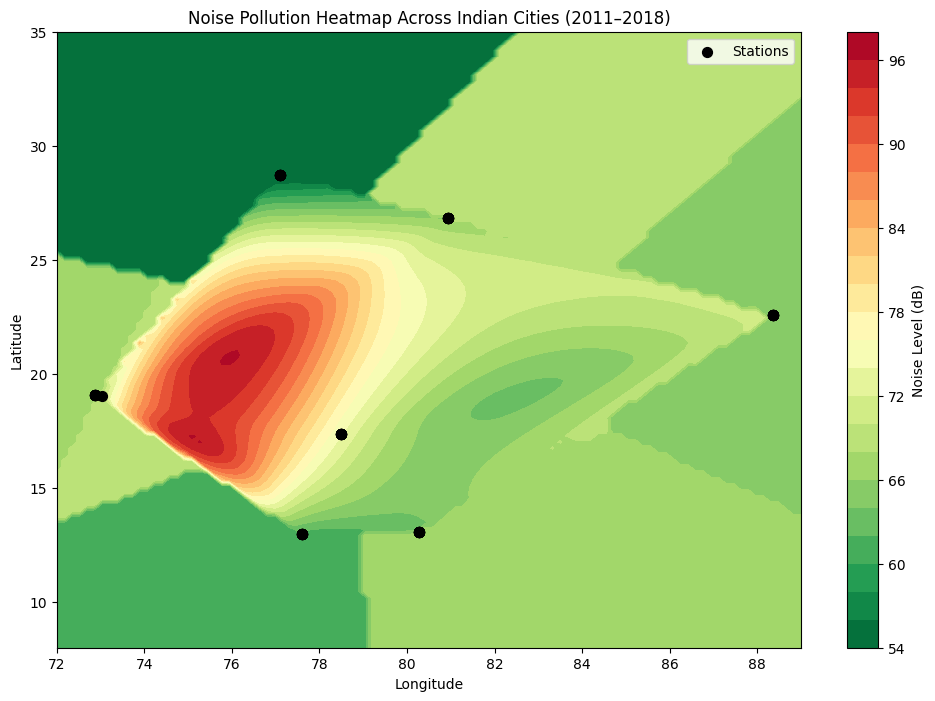

In [29]:
# Create heatmap
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z, cmap='RdYlGn_r', levels=20)
plt.colorbar(label='Noise Level (dB)')
plt.scatter(avg_noise['Longitude'], avg_noise['Latitude'], c='black', s=50, label='Stations')
plt.title('Noise Pollution Heatmap Across Indian Cities (2011–2018)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Save the interpolated data
np.savez('noise_heatmap.npz', X=X, Y=Y, Z=Z)
avg_noise.to_csv('avg_noise_stations.csv', index=False)

*The spatial noise pollution heatmap (2011–2018) spans Indian cities, with noise levels from 54 dB (green) to 96 dB (red).*


*  Bengaluru and Chennai show the highest noise (~90–96 dB), indicating severe pollution.

*  Mumbai and Hyderabad have moderate noise (~70–80 dB), reflecting urban activity.
*   Delhi and Lucknow are quieter (~54–65 dB), suggesting lower noise issues.

*   Sparse stations (e.g., Kolkata) may lead to underestimated noise levels.


*   High noise areas (>70 dB) pose health risks like stress and hearing loss.




